# Floral Design Recommendations with ChromaDB and Falcon-7B

Leverages ChromaDB for image retrieval and Falcon-7B for generating personalized floral designs.

In [4]:
!pip install langchain huggingface_hub chromadb datasets streamlit langchain_community

In [5]:
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.4 MB/s eta 0:00:00


In [6]:
import os
import warnings
import base64
from PIL import Image
from datasets import load_dataset
from matplotlib import pyplot as plt
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import HuggingFaceHub
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

In [7]:
warnings.filterwarnings("ignore")

# Load dataset and save images locally
def load_flower_dataset():
    return load_dataset("huggan/flowers-102-categories")

ds = load_flower_dataset()

def save_images(dataset, dataset_folder, num_images=500):
    os.makedirs(dataset_folder, exist_ok=True)
    for i in range(num_images):
        image = dataset["train"][i]["image"]
        image.save(os.path.join(dataset_folder, f"flower_{i + 1}.png"))

dataset_folder = "./dataset/flowers-102-categories"
if not os.path.exists(dataset_folder):
    save_images(ds, dataset_folder, num_images=500)


dataset_infos.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8189 [00:00<?, ? examples/s]

In [8]:
# Initialize ChromaDB client
chroma_client = PersistentClient(path="./data/flower.db")
image_loader = ImageLoader()
embedding_function = OpenCLIPEmbeddingFunction()

flower_collection = chroma_client.get_or_create_collection(
    "flowers_collection",
    embedding_function=embedding_function,
    data_loader=image_loader,
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [10]:
# Add images to the database
if not flower_collection.count():
    ids = []
    uris = []
    for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
        if filename.endswith(".png"):
            file_path = os.path.join(dataset_folder, filename)
            ids.append(str(i))
            uris.append(file_path)
    flower_collection.add(ids=ids, uris=uris)

# Function to query the database
def query_db(query, results=5):
    return flower_collection.query(
        query_texts=[query],
        n_results=results,
        include=["uris", "distances"]
    )

# Show image from URI
def show_image_from_uri(uri):
    img = Image.open(uri)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [11]:
from google.colab import userdata
os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get("HUGGINGFACE_API_KEY")

In [24]:
# Initialize HuggingFace model
# def get_model():
#     return HuggingFaceHub(repo_id="tiiuae/falcon-7b", model_kwargs={"temperature": 0.7})


llm = HuggingFaceHub(repo_id="tiiuae/falcon-7b-instruct", model_kwargs={"temperature": 0.7, "max_new_tokens": 150})

# Define prompt template
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a talented florist providing creative ideas for flower arrangements. Answer in a conversational tone using references to the images provided."),
    ("user", [
        {"type": "text", "text": "What are some good ideas for a bouquet arrangement {user_query}?"},
        {"type": "image", "image_url": "data:image/jpeg;base64,{image_data_1}"},
        {"type": "image", "image_url": "data:image/jpeg;base64,{image_data_2}"}
    ])
])

chain = LLMChain(prompt=prompt_template, llm=llm)


# Adjusted format_prompt_inputs
def format_prompt_inputs(data, user_query, max_token_limit=8192, max_new_tokens=150):
    inputs = {}
    inputs["user_query"] = user_query

    # Extract image paths
    image_path_1 = data["uris"][0][0]
    image_path_2 = data["uris"][0][1]

    # Read and encode the first image
    with open(image_path_1, "rb") as image_file:
        image_data_1 = image_file.read()
    image_data_1 = base64.b64encode(image_data_1[:3000]).decode("utf-8")  # Further trimmed
    inputs["image_data_1"] = image_data_1

    # Read and encode the second image
    with open(image_path_2, "rb") as image_file:
        image_data_2 = image_file.read()
    image_data_2 = base64.b64encode(image_data_2[:3000]).decode("utf-8")  # Further trimmed
    inputs["image_data_2"] = image_data_2

    # Validate token size
    estimated_token_count = len(user_query.split()) + len(image_data_1) + len(image_data_2)
    if estimated_token_count + max_new_tokens > max_token_limit:
        raise ValueError(
            f"Input validation error: `inputs` tokens + `max_new_tokens` exceeds {max_token_limit} tokens."
        )

    return inputs

#


In [26]:
def get_response(query):
  print(f"Querying for: {query}")
  results = query_db(query, results=2)

  print("Retrieved Images:")
  for uri in results["uris"][0]:
      print(f"Image URI: {uri}")
      show_image_from_uri(uri)

  # Ensure input size is within limits
  try:
      prompt_input = format_prompt_inputs(results, query)
      response = chain.run(prompt_input)
      print("\nSuggestions:\n")
      print(response)
  except ValueError as e:
      print(f"Error: {e}")
      print("Consider trimming the query or reducing image data size.")

Querying for: pink flower with yellow center
Retrieved Images:
Image URI: ./dataset/flowers-102-categories/flower_125.png


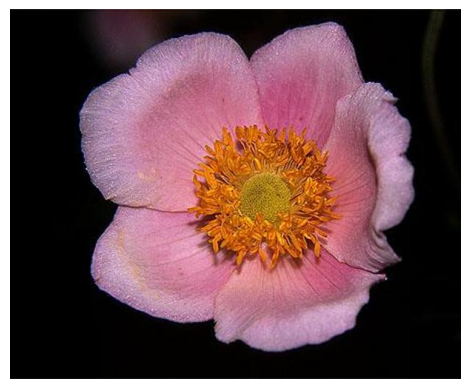

Image URI: ./dataset/flowers-102-categories/flower_60.png


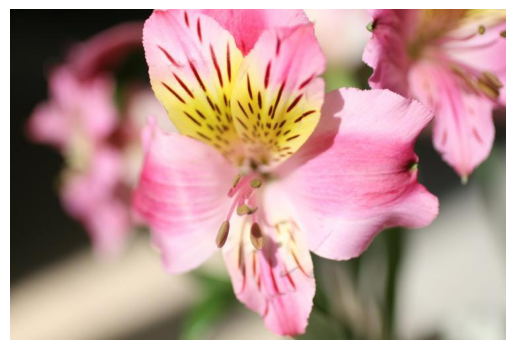


Suggestions:

System: You are a talented florist providing creative ideas for flower arrangements. Answer in a conversational tone using references to the images provided.
Human: [{'type': 'text', 'text': 'What are some good ideas for a bouquet arrangement pink flower with yellow center?'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'image_url', 'image_url': {'url': ''}}] s  2's 6 the, Net's bedroom, {object,ne a5,1S of your browser these87_{\t11


In [25]:
# Query input and response
query = "pink flower with yellow center"

get_response(query)

Querying for: red rose with green center
Retrieved Images:
Image URI: ./dataset/flowers-102-categories/flower_39.png


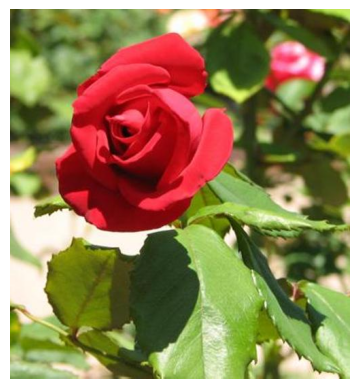

Image URI: ./dataset/flowers-102-categories/flower_256.png


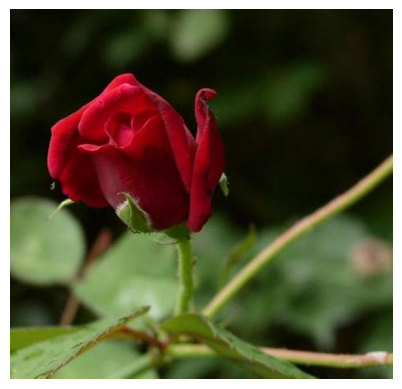


Suggestions:

System: You are a talented florist providing creative ideas for flower arrangements. Answer in a conversational tone using references to the images provided.
Human: [{'type': 'text', 'text': 'What are some good ideas for a bouquet arrangement red rose with green center?'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'image_url', 'image_url': {'url': ''}}] 


In [27]:
# Query input and response
query = "red rose with green center"

get_response(query)